<a href="https://colab.research.google.com/github/vakaanusha239/debug_session/blob/main/Dog_breed_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DOWNLOADING DATASETS FROM KAGGLE

For downloading the datasets from kaggle directly the following code helps but we need to upload the **kaggle api** file in the documents.

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

As our project's datasets are in kaggle competitions we can directly download them with following code. The content is downloaded in a **zip format**.

In [2]:
! kaggle competitions download -c dog-breed-identification 

 97% 670M/691M [00:04<00:00, 165MB/s]
100% 691M/691M [00:04<00:00, 149MB/s]


In [ ]:
#unzipping the files
! unzip dog-breed-identification.zip 

# IMPORTING REQUIRED LIBRARIES

In [5]:
import cv2
import numpy as np 
import pandas as pd 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input

#READING DATASETS

As the labels and images are downloaded in variours files, they are read by following code.

In [6]:
df_labels = pd.read_csv("labels.csv")
#store training and testing images folder location
train_file = 'train/'
test_file = 'test/'
print("Total number of unique Dog Breeds :",len(df_labels.breed.unique()))

Total number of unique Dog Breeds : 120


#PREPROCESSING

This step includes the adding of .jpg to the images names and resizing the images.

In [ ]:
num_breeds = 60 #there are 120 breeds available but we take only 60 breeds for the training purpose.
im_size = 224
batch_size = 64
encoder = LabelEncoder()
breed_dict = list(df_labels['breed'].value_counts().keys()) 
new_list = sorted(breed_dict,reverse=True)[:num_breeds*2+1:2]
df_labels = df_labels.query('breed in @new_list')
df_labels['img_file'] = df_labels['id'].apply(lambda x: x + ".jpg")

In [9]:
train_x = np.zeros((len(df_labels), im_size, im_size, 3), dtype='float32')
for i, img_id in enumerate(df_labels['img_file']):
  img = cv2.resize(cv2.imread(train_file+img_id,cv2.IMREAD_COLOR),((im_size,im_size)))
  img_array = preprocess_input(np.expand_dims(np.array(img[...,::-1].astype(np.float32)).copy(), axis=0))
  train_x[i] = img_array

In [10]:
train_y = encoder.fit_transform(df_labels["breed"].values)

#TRAINING AND TESTING SPLIT

Splitting the data into xtrain(independent train), xtest(independent test), ytrain(dependent train), ytest(dependent test)

In [11]:
x_train, x_test, y_train, y_test = train_test_split(train_x,train_y,test_size=0.2,random_state=42)

#AGUMENTATION

It is a process of adding extra data to the given data. This process includes zoom range of image shift ranges, modes of filling of different images.
 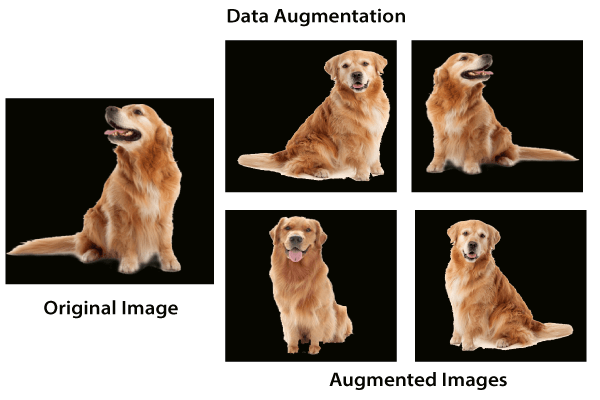

In [12]:
train_datagen = ImageDataGenerator(rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.25,
                                   horizontal_flip=True,
                                   fill_mode='nearest') 
train_generator = train_datagen.flow(x_train, 
                                     y_train, 
                                     batch_size=batch_size)
test_datagen = ImageDataGenerator()
 
test_generator = test_datagen.flow(x_test, 
                                     y_test, 
                                     batch_size=batch_size)

#BUILD THE MODEL 

For the model we use pre-trained ML Model named as **RESNET50V2**. Weights for our model are from **'ImageNet'** database. This type of technique is known as **Transfer learning**

In [13]:
resnet = ResNet50V2(input_shape = [im_size,im_size,3], weights='imagenet', include_top=False)

for layer in resnet.layers:
    layer.trainable = False
 
x = resnet.output
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x) 
x = Dropout(0.5)(x)

x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

94668760/94668760 [==============================] - 1s 0us/step


In [14]:
predictions = Dense(num_breeds, activation='softmax')(x)

model = Model(inputs=resnet.input, outputs=predictions)
#model.summary()

# TRAINING THE MODEL

In [15]:
epochs = 100
learning_rate = 1e-3
 
optimizer = RMSprop(learning_rate=learning_rate,rho=0.9)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

hist = model.fit(train_generator,
                 steps_per_epoch= x_train.shape[0] // batch_size,
                 epochs= epochs,
                 validation_data= test_generator,
                 validation_steps= x_test.shape[0] // batch_size)

model.save("model")

Epoch 1/100
31/31 [==============================] - 55s 1s/step - loss: 1.7834 - accuracy: 0.5374 - val_loss: 0.5811 - val_accuracy: 0.8237
Epoch 2/100
31/31 [==============================] - 29s 928ms/step - loss: 0.8511 - accuracy: 0.7480 - val_loss: 0.4467 - val_accuracy: 0.8683
Epoch 3/100
31/31 [==============================] - 38s 1s/step - loss: 0.6992 - accuracy: 0.7869 - val_loss: 0.3961 - val_accuracy: 0.8862
Epoch 4/100
31/31 [==============================] - 34s 1s/step - loss: 0.6345 - accuracy: 0.8031 - val_loss: 0.4027 - val_accuracy: 0.8772
Epoch 5/100
31/31 [==============================] - 29s 950ms/step - loss: 0.5919 - accuracy: 0.8112 - val_loss: 0.4337 - val_accuracy: 0.8683
Epoch 6/100
31/31 [==============================] - 30s 954ms/step - loss: 0.5198 - accuracy: 0.8209 - val_loss: 0.4136 - val_accuracy: 0.8795
Epoch 7/100
31/31 [==============================] - 31s 984ms/step - loss: 0.5335 - accuracy: 0.8295 - val_loss: 0.4412 - val_accuracy: 0.8683
E

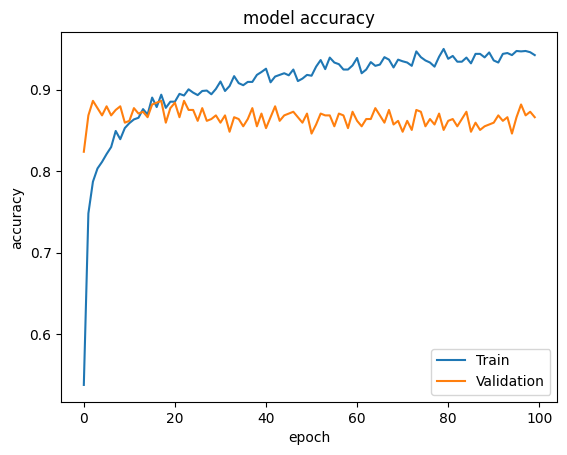

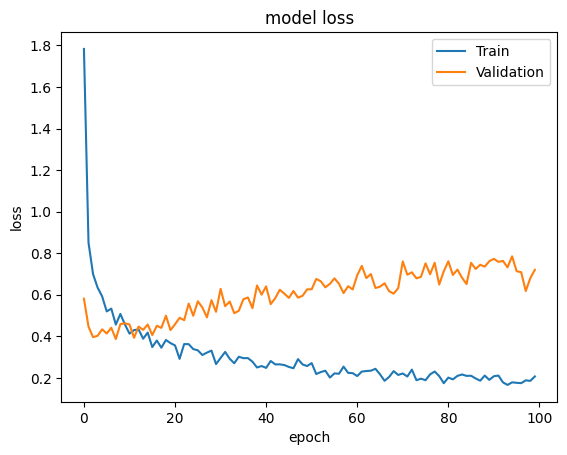

In [16]:
#from IPython.core import history
import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'],loc='lower right')
plt.show()
# summarize model for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

TEST THE MODEL

1/1 [==============================] - 2s 2s/step


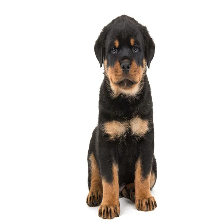

Predicted Breed for this Dog is : rottweiler


In [17]:
from google.colab.patches import cv2_imshow
model = load_model("model")
pred_img_path = '/content/pred1.webp'
pred_img_array = cv2.resize(cv2.imread(pred_img_path,cv2.IMREAD_COLOR),((im_size,im_size)))
pred_img_array = preprocess_input(np.expand_dims(np.array(pred_img_array[...,::-1].astype(np.float32)).copy(), axis=0))

pred_val = model.predict(np.array(pred_img_array,dtype="float32"))

cv2_imshow(cv2.resize(cv2.imread(pred_img_path,cv2.IMREAD_COLOR),((im_size,im_size))))
 
#display the predicted breed of dog
pred_breed = sorted(new_list)[np.argmax(pred_val)]
print("Predicted Breed for this Dog is :",pred_breed)

1/1 [==============================] - 0s 35ms/step


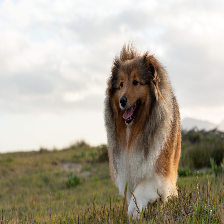

Predicted Breed for this Dog is : shetland_sheepdog


In [18]:
pred_img_path1='/content/pred2.jpg'
pred_img_array = cv2.resize(cv2.imread(pred_img_path1,cv2.IMREAD_COLOR),((im_size,im_size)))
pred_img_array = preprocess_input(np.expand_dims(np.array(pred_img_array[...,::-1].astype(np.float32)).copy(), axis=0))

pred_val = model.predict(np.array(pred_img_array,dtype="float32"))

cv2_imshow(cv2.resize(cv2.imread(pred_img_path1,cv2.IMREAD_COLOR),((im_size,im_size))))
 
#display the predicted breed of dog
pred_breed = sorted(new_list)[np.argmax(pred_val)]
print("Predicted Breed for this Dog is :",pred_breed)